## Libraries 

In [2]:
import random
import numpy as np
import string
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras import layers

## Morse dictionary

In [3]:
# basic morse dictionary, we use '-' to mark word spaces

alphabet = list('abcdefghijklmnopqrstuvwxyz-')
values = ['.-', '-...', '-.-.', '-..', '.', '..-.', '--.', '....', '..', '.---', '-.-', 
          '.-..', '--', '-.','---', '.--.', '--.-', 
          '.-.', '...', '-', '..-', '...-', '.--', '-..-', '-.--', '--..','-....-']

morse_dict = dict(zip(alphabet, values))
ascii_dict = dict(map(reversed, morse_dict.items())) # inverse mapping

# convert text to morse code
def morse_encode(text):
    t = ''.join([c for c in text.lower() if c in alphabet])
    return ' '.join([''.join(morse_dict[i]) for i in t])
 
# convert morse code to text
def morse_decode(code):
    return ''.join([ascii_dict[i] for i in code.split(' ')])

## Generating data for training

In [4]:
word_len = 6                                    # number of characters output

max_len_x = len(max(values, key=len))*word_len+(word_len-1)  # number of morse symbols
max_len_y = word_len
    
# generate data for training 

def generate_data (n):
    output_list = [(''.join([random.choice(string.ascii_lowercase + '-') 
        for _ in range(word_len)])) 
            for _ in range(n)]
    return  output_list, [morse_encode(s) for s in output_list]
    
output_list, input_list = generate_data(10000)

## Embedding, simply my mapping a one-hot encoding

In [5]:
class Embedding(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in
                                            enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in 
                                            enumerate(self.chars))
    def encode(self, token, num_rows):
        x = np.zeros((num_rows, len(self.chars)))   # zeros, except ..
        for i, c in enumerate(token):               # one 
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x):
        x = [x.argmax(axis=-1)]
        return ''.join(self.indices_char[int(v)] for v in x)
    

## Prepare data for feeding to network, i.e. represent by one-hot encoding

In [6]:
# character sets used at input (morse code) and output (text)

chars_in = '-. '
chars_out = ''.join(alphabet)

embedding_in = Embedding(chars_in)
embedding_out = Embedding(chars_out)

# x : input to encoder, y : output from decoder
x = np.zeros((len(input_list), max_len_x, len(chars_in)))
y = np.zeros((len(output_list), max_len_y, len(chars_out)))

for i, token in enumerate(input_list):
    x[i] = embedding_in.encode(token, max_len_x)
    
for i, token in enumerate(output_list):
    y[i] = embedding_out.encode(token, max_len_y)
    
# split data set : 3/4 for training, 1/4 for evaluation
m = 3*len(x)// 4
(x_train, x_val) = x[:m], x[m:]
(y_train, y_val) = y[:m], y[m:]

# show some examples ...
for i in range(5):
    print(''.join([embedding_in.decode(token) for token in x_train[i]]),
          ''.join([embedding_out.decode(token) for token in y_train[i]]))

...- .. -... .-. -.- .-.                  vibrkr
-... --.- ... -... .--. ..                bqsbpi
--.- .-. ..- ...- . -.-                   qruvek
-.-. -.-- .--. ...- .-.. ..-.             cypvlf
-.-. ..-. ... --.- -.. --                 cfsqdm


## Create model

In [7]:
latent_dim = 200

model = Sequential()
model.add(layers.LSTM(latent_dim, input_shape=(max_len_x,len(chars_in))))
model.add(layers.RepeatVector(max_len_y))
model.add(layers.LSTM(latent_dim, return_sequences=True))
model.add(layers.TimeDistributed(layers.Dense(len(chars_out))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 200)               163200    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 6, 200)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 200)            320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 6, 27)             5427      
_________________________________________________________________
activation (Activation)      (None, 6, 27)             0         
Total params: 489,427
Trainable params: 489,427
Non-trainable params: 0
_________________________________________________________________


## Train model

Epoch 1/74
150/150 [==============================] - 6s 42ms/step - loss: 3.1799 - accuracy: 0.0707 - val_loss: 3.1167 - val_accuracy: 0.0861
Epoch 2/74
150/150 [==============================] - 6s 39ms/step - loss: 3.0619 - accuracy: 0.0959 - val_loss: 3.0097 - val_accuracy: 0.1037
Epoch 3/74
150/150 [==============================] - 6s 39ms/step - loss: 2.9666 - accuracy: 0.1130 - val_loss: 2.9450 - val_accuracy: 0.1220
Epoch 4/74
150/150 [==============================] - 6s 41ms/step - loss: 2.8651 - accuracy: 0.1376 - val_loss: 2.8443 - val_accuracy: 0.1452
Epoch 5/74
150/150 [==============================] - 6s 41ms/step - loss: 2.7712 - accuracy: 0.1680 - val_loss: 2.7292 - val_accuracy: 0.1824
Epoch 6/74
150/150 [==============================] - 6s 43ms/step - loss: 2.6560 - accuracy: 0.2016 - val_loss: 2.6220 - val_accuracy: 0.2069
Epoch 7/74
150/150 [==============================] - 6s 42ms/step - loss: 2.5523 - accuracy: 0.2319 - val_loss: 2.5631 - val_accuracy: 0.2261

Epoch 58/74
150/150 [==============================] - 7s 44ms/step - loss: 0.0277 - accuracy: 0.9990 - val_loss: 0.0300 - val_accuracy: 0.9981
Epoch 59/74
150/150 [==============================] - 7s 45ms/step - loss: 0.0226 - accuracy: 0.9989 - val_loss: 0.0363 - val_accuracy: 0.9950
Epoch 60/74
150/150 [==============================] - 7s 44ms/step - loss: 0.0319 - accuracy: 0.9963 - val_loss: 0.0527 - val_accuracy: 0.9901
Epoch 61/74
150/150 [==============================] - 7s 44ms/step - loss: 0.0387 - accuracy: 0.9944 - val_loss: 0.0603 - val_accuracy: 0.9873
Epoch 62/74
150/150 [==============================] - 7s 46ms/step - loss: 0.0956 - accuracy: 0.9729 - val_loss: 0.1718 - val_accuracy: 0.9451
Epoch 63/74
150/150 [==============================] - 7s 45ms/step - loss: 0.1166 - accuracy: 0.9662 - val_loss: 0.0957 - val_accuracy: 0.9705
Epoch 64/74
150/150 [==============================] - 7s 46ms/step - loss: 0.0416 - accuracy: 0.9932 - val_loss: 0.0289 - val_accuracy:

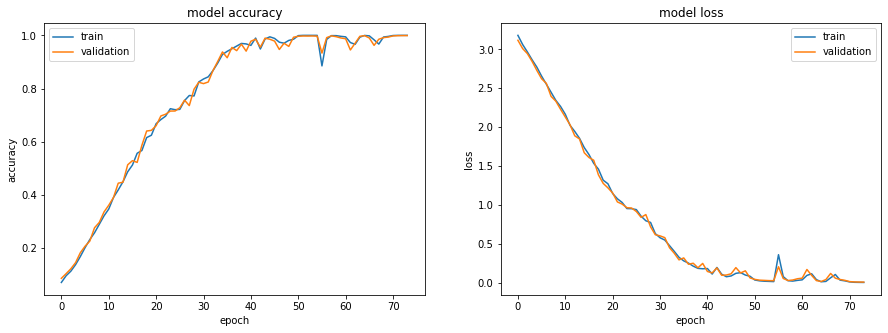

In [8]:
Epochs = 74
Batch_size = 50

# train
hist = model.fit(x_train, y_train, 
                 batch_size=Batch_size, epochs=Epochs, 
                 validation_data=(x_val, y_val))

#show history of progress
def show_progress():
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

show_progress()

## Test model

In [15]:
test = ['abcdef', '-hslu-','hahaha','------','xyzuvw','pipapo','hello-','world-', '----fh']
        
x = np.zeros((len(test), max_len_x, len(chars_in)))
for i, token in enumerate(test):
    x[i] = embedding_in.encode(morse_encode(token), max_len_x)

pre = model.predict(x)

for i in range(len(test)):
    print(''.join([embedding_in.decode(code) for code in x[i]]),
          ''.join([embedding_out.decode(code) for code in pre[i]]), ' <-> ', 
          ''.join(test[i]))

.- -... -.-. -.. . ..-.                   abcdef  <->  abcdef
-....- .... ... .-.. ..- -....-           -hslu-  <->  -hslu-
.... .- .... .- .... .-                   hahaha  <->  hahaha
-....- -....- -....- -....- -....- -....- ------  <->  ------
-..- -.-- --.. ..- ...- .--               xyzuvw  <->  xyzuvw
.--. .. .--. .- .--. ---                  pipapo  <->  pipapo
.... . .-.. .-.. --- -....-               hello-  <->  hello-
.-- --- .-. .-.. -.. -....-               world-  <->  world-
-....- -....- -....- -....- ..-. ....     ----hh  <->  ----fh


## Save and load models

In [11]:
model.save('model_best.h5')


In [3]:
mx = load_model('model_best.h5')
